## Introduction

You are working as an ML engineer in Visiemo, a famous sound-based sentiment analysis company. It’s Monday morning and you are chilling at the coffee machine with fellow Visiumees. Suddenly, the AI project manager schedules you a project kick-off meeting. A multinational client is interested in our services: the client has different call centers around the world and would like to analyze the satisfaction of its customers based on the recordings of the calls.

The client has heard about AI and Visiemo, more precisely about our expertise in sentiment analysis.
However,the client is reluctant in whether the solution will work. As such, it has been agreed to first do a proof-of-concept on the call centers from Germany.

At Visiemo, we have decided to use an already existing dataset and design a small proof-of-concept to showcase the solution to the client.

## Instructions

In the frame of this use-case, you will be confronted to **Speech Emotion Recognition** with the **Emo-DB** dataset. The goal is to design a proof-of-concept model which classifies samples of emotional speech in one of the given emotions.

By the end of the use-case, you should have a working model with good enough performance, fairly evaluated. 

*We do not aim to have the best performing model.* On the contrary, you should aim for an end-to-end working solution that enables inference on new speech samples.

* As a **report**, you should fill in the present notebook.
* You should dockerize your project. The **Docker container** should handle everything (download the data, run the code, etc.). When running the container **it should expose the Jupyter notebook on one port and expose a Flask API on another one**.
* The **Flask API** should contain two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* The code that you will develop should be **entirely reproducible** and **documented in a README.md file**.

## Final presentation

* The final presentation will be held on-site or remotely depending on your availability. 
* An AI Project Manager and two ML engineers will be present. 
* You will start by giving a 10-15 min technical presentation about your approach and your findings, using the slides provided as deliverables. Finally, a discussion with questions of about 20 min will follow.
* It should be clear enough to understand your approach and your decisions without going too much in the code. 
* You can also include code snippets, demos, etc.

## Important points to keep in mind

* Please be aware that this use-case might take a substantial amount of time, especially if you are not familiar with all the tools.
* You will have one full week to tackle the problem, starting today. We broadly estimate to *15-20 hours* the usual development time needed.
* Don’t spend too much time finding the perfect technical solution or making tiny metric improvements. 
* If you don't manage to finish all the tasks, you can still send us your use-case: we will discuss the difficulties you encountered during the final presentation.
* **Do not upload your code to Github, or at least not in a public repo.**
* Feel free to use any available library you would need, but **do not re-use someone else's code without mentioning it.**

## Deliverables 

Please provide the following elements in a **.zip** file as deliverables:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work.
* A **Dockerfile** defining a container for the project expositing the present notebook and the Flask API.
* A **README.md** which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* **Any** necessary .py, .sh or other files needed to run your code.

You will be judged on your technical approach, evaluation, visualizations, coding and presentation skills.

## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [1]:
from os import listdir, getcwd
from os.path import join, dirname
import pandas as pd
import librosa

from src import formatData
from src import plot_audio
from src import extractFeatures
from src import evaluation

# Data Preparation & Cleaning

### Data Loading

In [2]:
PATH_DATA = join(getcwd(), 'download', 'wav')

data = formatData.createDataFrame(PATH_DATA)

data.head(5)

,id,user_id,text_id,label,versions,emotion,ts,sr,len_ts
0,16a02Lb,16,a02,L,b,boredom,"[0.00124133, 0.0010521726, 0.0004256508, 0.000...",22050,45889
1,14a07Wc,14,a07,W,c,anger,"[6.805249e-06, 1.2503062e-05, -3.899378e-05, -...",22050,45501
2,10a07Ad,10,a07,A,d,fear,"[0.0011187387, 0.0011917101, 0.0005759509, -0....",22050,35355
3,13a05Ea,13,a05,E,a,disgust,"[0.0014452776, 0.0008329833, -0.0003924449, -0...",22050,92521
4,14a05Wa,14,a05,W,a,anger,"[0.0003161473, 0.00027575556, 3.9782277e-05, -...",22050,88351


### EDA

In [3]:
import numpy as np

print(f'There are {data.shape[0]} recordings')
print(f'There are {len(np.unique(data.loc[:,"user_id"]))} different users')
print(f'There are {len(np.unique(data.loc[:,"text_id"]))} different text id')


There are 535 recordings
There are 10 different users
There are 10 different text id


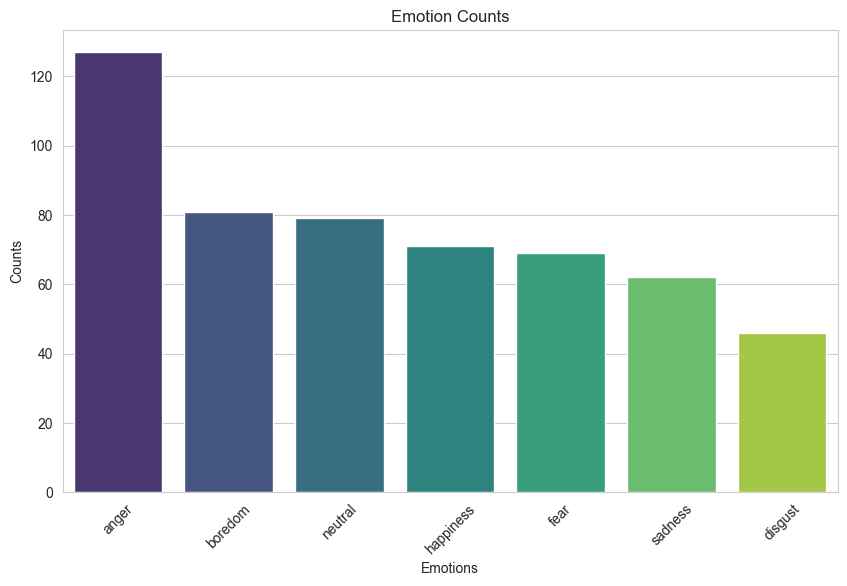

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

emotions = ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
counts = [127, 81, 46, 69, 71, 79, 62]

sorted_data = sorted(zip(emotions, counts), key=lambda x: x[1], reverse=True)
sorted_emotions, sorted_counts = zip(*sorted_data)

sns.set_style("whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the bar plot
sns.barplot(x=list(sorted_emotions), y=list(sorted_counts), palette='viridis')

# Set the labels and title
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Counts')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Visualize Time Series

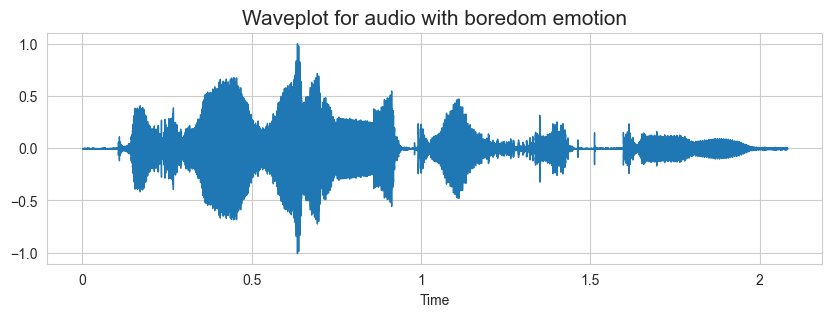

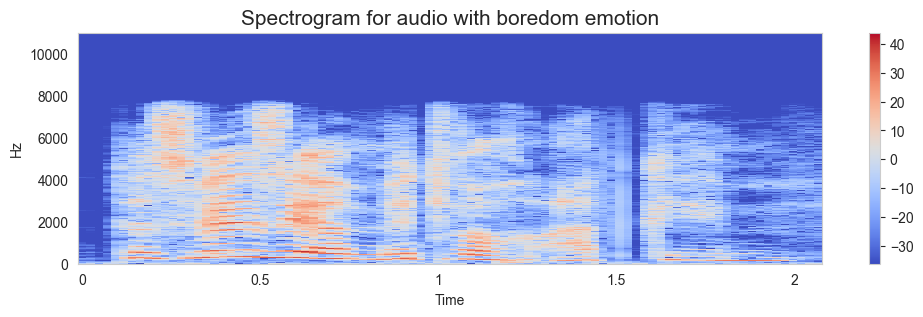

In [5]:
ts = data.loc[0, 'ts']
sr = data.loc[0, 'sr']


plot_audio.create_waveplot(ts, sr, 'boredom')
plot_audio.create_spectrogram(ts, sr, 'boredom')

## Divide Train Test

3 users to test

In [6]:
import random
def splitTrainTestByUser(data: pd.DataFrame, test_size:float = 0.2, random_state:int = 42):
    users = np.unique(data.loc[:,'user_id'].values.tolist())
    num_test = int(len(users)*test_size)

    random.seed(random_state)
    users_test = random.sample(list(users), num_test)

    train = data.loc[~data.loc[:,'user_id'].isin(users_test),]
    test = data.loc[data.loc[:,'user_id'].isin(users_test),]

    return train, test


In [7]:
train, test = splitTrainTestByUser(data)

# Feature Engineering & Modeling

### Features

* Zero Cross Rate
* Energy
* Entropy of Energy
* Spectral Centroid
* Spectral Spread
* Spectral Entropy
* Spectral Flux
* Spectral Roll off
* MFCC
* Chroma Vector
* Chroma Deviation


Fisher test

In [8]:
train

,id,user_id,text_id,label,versions,emotion,ts,sr,len_ts
0,16a02Lb,16,a02,L,b,boredom,"[0.00124133, 0.0010521726, 0.0004256508, 0.000...",22050,45889
1,14a07Wc,14,a07,W,c,anger,"[6.805249e-06, 1.2503062e-05, -3.899378e-05, -...",22050,45501
2,10a07Ad,10,a07,A,d,fear,"[0.0011187387, 0.0011917101, 0.0005759509, -0....",22050,35355
3,13a05Ea,13,a05,E,a,disgust,"[0.0014452776, 0.0008329833, -0.0003924449, -0...",22050,92521
4,14a05Wa,14,a05,W,a,anger,"[0.0003161473, 0.00027575556, 3.9782277e-05, -...",22050,88351
...,...,...,...,...,...,...,...,...,...
526,12b01Ta,12,b01,T,a,sadness,"[1.6248066e-05, 0.0001822404, 0.00053973217, 0...",22050,88100
527,10b10Fc,10,b10,F,c,happiness,"[0.00026165482, 0.00016800033, 2.5701285e-05, ...",22050,48770
528,15a07Ac,15,a07,A,c,fear,"[3.4620225e-05, 0.00010058556, 0.00024988115, ...",22050,39930
532,09a05Lc,09,a05,L,c,boredom,"[-0.042633273, -0.048330702, -0.041187566, -0....",22050,74251


In [9]:
code_emotions = {'W': 'anger', 'L':'boredom', 'E':'disgust', 'A':'fear',
                'F':'happiness', 'T':'sadness', 'N':'neutral'}
label2int = {'N':0, 'A':1, 'E':2, 'F':3, 'L':4, 'T':5, 'W':6}
emotion2int = {'neutral':0, 'fear':1, 'disgust':2, 'happiness':3, 'boredom':4, 'sadness':5, 'anger':6}

In [10]:
from src.extractFeatures import FeatureExtractor

extractFeatures = FeatureExtractor()

X_train = np.apply_along_axis(lambda x: extractFeatures(x[0], x[1]), axis=1, arr=np.array(train.loc[:,['ts', 'sr']].values))
y_train = train.loc[:,'label'].apply(lambda x: label2int[x]).values

X_test = np.apply_along_axis(lambda x: extractFeatures(x[0], x[1]), axis=1, arr=np.array(test.loc[:,['ts', 'sr']].values))
y_test = test.loc[:,'label'].apply(lambda x: label2int[x]).values

### Anova Feature Selection

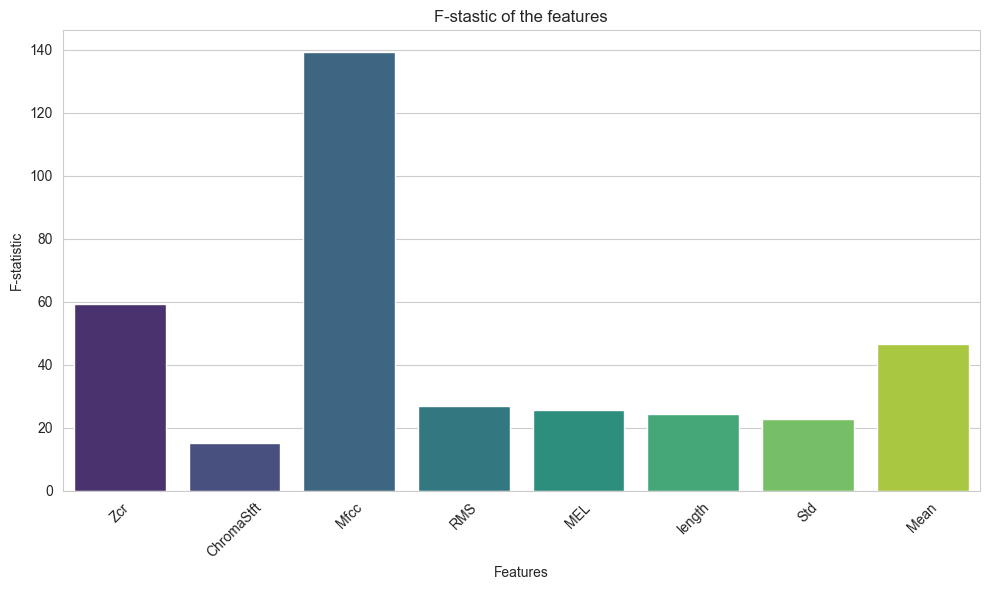

In [11]:
feature_names = extractFeatures.features

from sklearn.feature_selection import f_classif
f_value = f_classif(X_train, y_train)


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=f_value[0], palette="viridis")
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.title('F-stastic of the features')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot

### Define model

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder


model = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(oob_score=True))
])

model.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('cls', RandomForestClassifier(oob_score=True))])

In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score
def CrossValidationByUser(X, y_true, model, users_id):

    unique_users = np.unique(users_id)

    f1s = []
    precisions = []
    recalls = []

    for user in unique_users:
        indexes_val = np.where(users_id == user)[0]
        indexes_train = np.where(users_id!= user)[0]

        X_train = X[indexes_train]
        y_train = y_true[indexes_train]


        X_val = X[indexes_val]
        y_val = y_true[indexes_val]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        f1s.append(f1_score(y_val, preds, average='macro', zero_division=0))
        precisions.append(precision_score(y_val, preds, average='macro', zero_division=0))
        recalls.append(recall_score(y_val, preds, average='macro', zero_division=0))

    print('|F1|Precision|Recall|')
    print('|:---:|:---:|:----:|')
    
    means = [np.mean(metric) for metric in [f1s, precisions, recalls]]
    stds = [np.std(metric) for metric in [f1s, precisions, recalls]]

    print(f'|{means[0]:.02f}+-{stds[0]:.02f}|{means[1]:.02f}+-{stds[1]:.02f}|{means[2]:.02f}+-{stds[2]:.02f}|')

    return None

CrossValidationByUser(X_train, y_train, model, train.loc[:,'user_id'].values)

|F1|Precision|Recall|
|:---:|:---:|:----:|
|0.42+-0.17|0.48+-0.18|0.44+-0.17|


# Results & Visualizations

### Compare Models

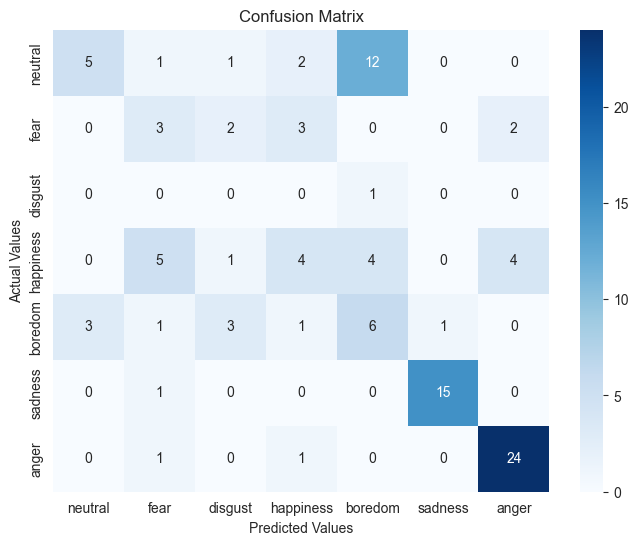

Results model with username where accuracy is:  0.5327102803738317
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.62|0.24|0.34|
|fear|0.25|0.30|0.27|
|disgust|0.00|0.00|nan|
|happiness|0.36|0.22|0.28|
|boredom|0.26|0.40|0.32|
|sadness|0.94|0.94|0.94|
|anger|0.80|0.92|0.86|


/Users/alejandrobonell/visium_homework/src/evaluation.py:63: RuntimeWarning: invalid value encountered in divide
  f1 = 2*recall*precision/(recall+precision)


In [14]:
evaluation.metrics_report(y_test, model.predict(X_test), emotion2int)

Results model with username where accuracy is:  0.5185185185185185
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.48|0.43|0.46|
|fear|0.36|0.20|0.26|
|disgust|0.00|0.00|nan|
|happiness|0.64|0.35|0.45|
|boredom|0.27|0.48|0.34|
|sadness|0.77|0.74|0.76|
|anger|0.88|0.81|0.85|

### Error Analysis